# Eppstein アルゴリズム実装

**入力**<br>
DiGraph (networkx)<br>
**開発環境**<br>
MacOS Mojave 10.14.3<br>
Python3.7<br>
networkx 2.2<br>
**参考**<br>
Eppstein, David. "Finding the k shortest paths." SIAM Journal on computing 28.2 (1998): 652-673.<br>

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from heap_tree import BinaryTree
from copy import deepcopy
from heapq import heappush, heappop
from collections import defaultdict
from csv import reader as csv_reader

In [17]:
def plot_digraph(digraph, pos, title, node_size=1400, figsize=None, ax=None):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.yaxis.set_major_locator(ticker.NullLocator()) # 軸のメモリを消す
    ax.xaxis.set_major_locator(ticker.NullLocator())
    nx.draw_networkx_nodes(digraph, pos, node_size=node_size, node_color='mediumseagreen', node_shape='o', alpha=0.8, ax=ax)
    nx.draw_networkx_edges(digraph, pos, width=1.0, edge_color='k', arrowstyle='-|>', arrowsize=30, ax=ax)
    nx.draw_networkx_labels(digraph, pos, labels=None, font_size=12, font_color='k',font_weight='normal', alpha=1.0, ax=ax)
    nx.draw_networkx_edge_labels(digraph, pos, edge_labels={edge: digraph.edges[edge]['weight'] for edge in digraph.edges()}, ax=ax)
    plt.savefig(f"{'_'.join(title.split())}.pdf")
def plot_digraph2(digraph, pos, T, weight, title, figsize=None):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.yaxis.set_major_locator(ticker.NullLocator()) # 軸のメモリを消す
    ax.xaxis.set_major_locator(ticker.NullLocator())
    nx.draw_networkx_nodes(digraph, pos, node_size=1400, node_color='mediumseagreen', node_shape='o', alpha=0.8, ax=ax)
    for edge in digraph.edges():
        if edge not in T.edges():
            nx.draw_networkx_edges(digraph, pos, edgelist=[edge], width=1 + digraph.edges[edge][weight], edge_color='k', arrowstyle='-|>', arrowsize=30, ax=ax)
    nx.draw_networkx_labels(digraph, pos, labels=None, font_size=12, font_color='k',font_weight='normal', alpha=1.0, ax=ax)
    nx.draw_networkx_edge_labels(digraph, pos, edge_labels={edge: G.edges[edge][weight] for edge in G.edges() if edge not in T.edges()}, ax=ax)
    plt.savefig(f"{'_'.join(title.split())}.pdf")
def plot_digraph3(digraph, pos, title, node_size=1400, figsize=None, labels=None):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.yaxis.set_major_locator(ticker.NullLocator()) # 軸のメモリを消す
    ax.xaxis.set_major_locator(ticker.NullLocator())
    nx.draw_networkx_nodes(digraph, pos, node_size=node_size, node_color='mediumseagreen', node_shape='o', alpha=0.8, ax=ax)
    for edge in digraph.edges():
        if digraph.edges[edge]['edge_type'] == 'heap_edge':
            nx.draw_networkx_edges(digraph, pos, edgelist=[edge], width=1.0, edge_color='k', arrowstyle='-|>', arrowsize=30, ax=ax)
        if digraph.edges[edge]['edge_type'] == 'cross_edge':
            nx.draw_networkx_edges(digraph, pos, edgelist=[edge], width=1.0, edge_color='r', arrowstyle='-|>', arrowsize=30, ax=ax)
        if digraph.edges[edge]['edge_type'] == 'root_edge':
            nx.draw_networkx_edges(digraph, pos, edgelist=[edge], width=1.0, edge_color='g', arrowstyle='-|>', arrowsize=30, ax=ax)
    nx.draw_networkx_labels(digraph, pos, labels=labels, font_size=12, font_color='k',font_weight='normal', alpha=1.0, ax=ax)
    plt.savefig(f"{'_'.join(title.split())}.pdf")
def plot_digraph4(digraph, path, pos, title, node_size=1400, figsize=None, labels=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.yaxis.set_major_locator(ticker.NullLocator()) # 軸のメモリを消す
    ax.xaxis.set_major_locator(ticker.NullLocator())
    nx.draw_networkx_nodes(digraph, pos, node_size=node_size, node_color='mediumseagreen', node_shape='o', alpha=0.8, ax=ax)
    nx.draw_networkx_edges(digraph, pos, width=1.0, edge_color='k', arrowstyle='-|>', arrowsize=30, ax=ax)
    nx.draw_networkx_labels(digraph, pos, labels=None, font_size=12, font_color='k',font_weight='normal', alpha=1.0, ax=ax)
    nx.draw_networkx_edge_labels(digraph, pos, edge_labels={edge: digraph.edges[edge]['weight'] for edge in digraph.edges()}, ax=ax) 
    for v, u in zip(path, path[1:]):
        nx.draw_networkx_edges(digraph, pos, edgelist=[(v, u)], width=8.0, edge_color='r', arrowstyle='-|>', arrowsize=30, alpha=0.3, ax=ax)

In [18]:
edges = {'C': {'D': {'weight': 3}, 'E': {'weight': 2}},
         'D': {'E': {'weight': 2}, 'F': {'weight': 4}},
         'E': {'F': {'weight': 2}, 'G': {'weight': 3}},
         'F': {'H': {'weight': 2}, 'G': {'weight': 3}},
         'G': {'H': {'weight': 2}}}
pos = {'C': (0, 1),
       'D': (1, 1),
       'E': (1, 0),
       'F': (2, 1),
       'G': (2, 0),
       'H': (3, 0)}
G = nx.DiGraph(edges)
source = 'C'
target = 'H'
K = 100

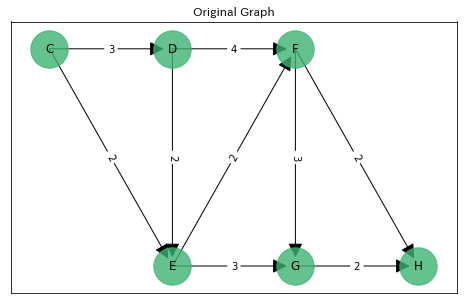

In [19]:
plot_digraph(G, pos, title='Original Graph', figsize=(8, 5))

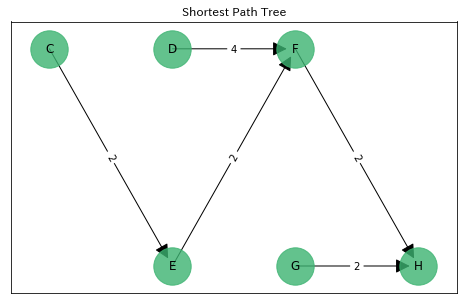

In [20]:
pred, distance = nx.dijkstra_predecessor_and_distance(G.reverse(), source=target)

# shortest path tree
T = G.edge_subgraph((i, pred[i][0]) for i in pred if pred[i])
plot_digraph(T, pos, title='Shortest Path Tree', figsize=(8, 5))

for edge in G.edges():
    tail, head = edge
    G[tail][head]['delta'] = G[tail][head]['weight'] + distance[head] - distance[tail]

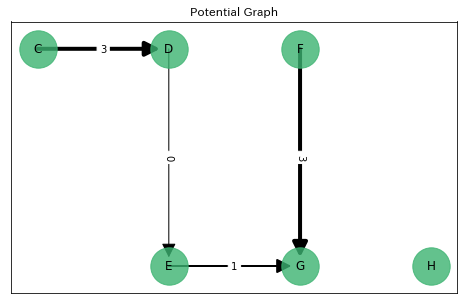

In [21]:
plot_digraph2(G, pos, T, 'delta', title='Potential Graph', figsize=(8, 5))

In [22]:
def out(v, G, T):
    out_edges = []
    for head in G[v]:
        if head not in T[v]:
            out_edges.append((v, head))
    return out_edges

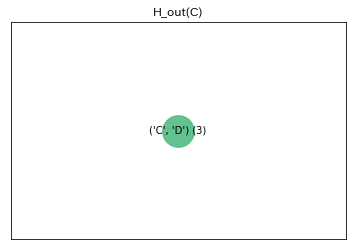

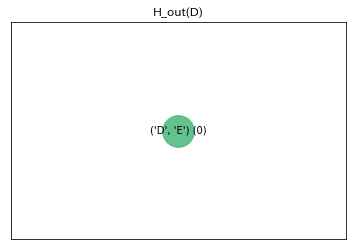

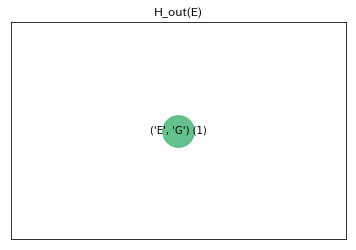

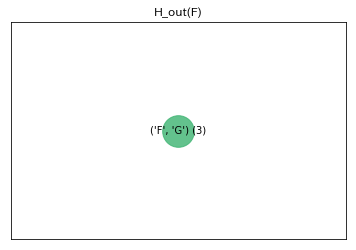

In [23]:
# generate H_out tree
for v in G:
    out_edges = sorted(out(v, G, T))
    h_out_tree = BinaryTree()
    if out_edges:
        max_root, *other_edges = out_edges
        for edge in other_edges:
            h_out_tree.insert(edge, G.edges[edge]['delta'])
        h_out_tree.insert(max_root, G.edges[max_root]['delta'])
    G.node[v]['H_out'] = h_out_tree
for v in G:
    G.node[v]['H_out'].draw_tree(title=f"H_out({v})")

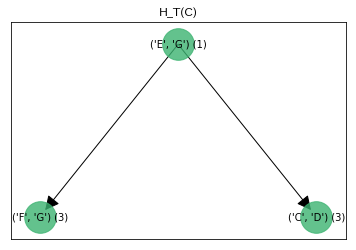

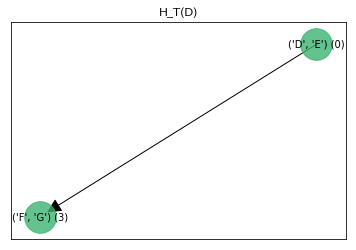

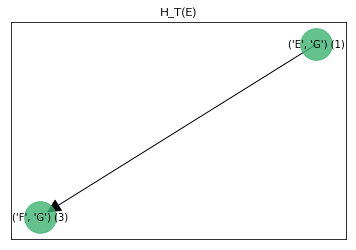

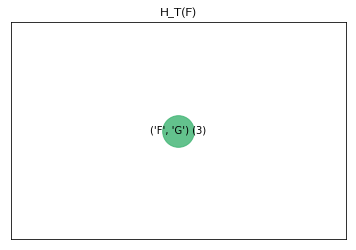

In [24]:
# generate H_T tree
h_t_tree = BinaryTree()
out_root = G.node[target]['H_out'].root
if out_root is not None:
    h_t_tree.insert(out_root.name, out_root.value)
G.node[target]['H_T'] = h_t_tree
for edge in nx.bfs_edges(T.reverse(), source=target):
    h_t_tree = deepcopy(G.node[edge[0]]['H_T'])
    out_root = G.node[edge[1]]['H_out'].root
    if out_root is not None:
        h_t_tree.insert(out_root.name, out_root.value)
    G.node[edge[1]]['H_T'] = h_t_tree
for v in G:
    G.node[v]['H_T'].draw_tree(title=f"H_T({v})")

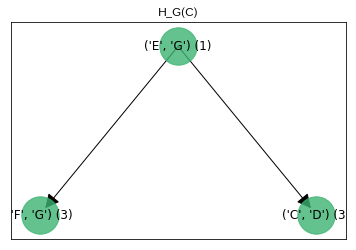

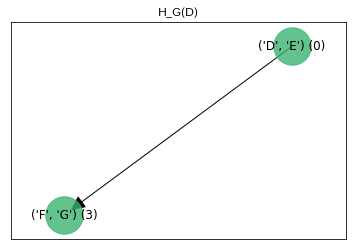

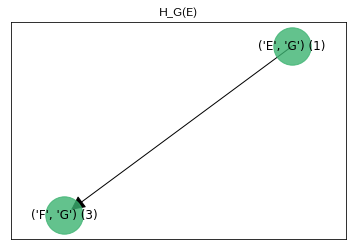

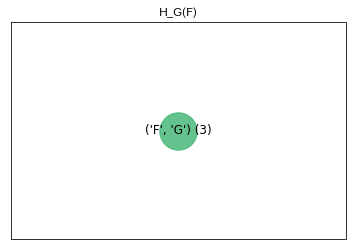

In [25]:
# generate H_G tree
h_g_tree = deepcopy(G.node[target]['H_T'])
h_g_tree.h_out_insert(G.node[target]['H_out'])
G.node[target]['H_G'] = h_g_tree
for edge in nx.bfs_edges(T.reverse(), source=target):
    _, child = edge
    h_g_tree = G.node[child]['H_T']
    for v in nx.shortest_path(T, source=child, target=target):
        h_g_tree.h_out_insert(G.node[v]['H_out'])
    G.node[child]['H_G'] = h_g_tree
for v in G:
    G.node[v]['H_G'].draw_tree2(title=f"H_G({v})")

In [26]:
# generate path-graph P
def edge2delta(G, edge):
    return G[edge[0]][edge[1]]['delta']
def add_H_G_to_P(P, node):
    for v in G.node[node]['H_G'].traverse():
        v_name = (node, v.name)
        P.add_node(v_name)
        if v.left  is not None:
            u_name = (node, v.left.name)
            weight = edge2delta(G, v.left.name) - edge2delta(G, v.name)
            P.add_edge(v_name, u_name, weight=weight, edge_type='heap_edge')
        if v.right is not None:
            u_name = (node, v.right.name)
            weight = edge2delta(G, v.right.name) - edge2delta(G, v.name)
            P.add_edge(v_name, u_name, weight=weight, edge_type='heap_edge')
        if v.h_out is not None:
            u_name = (node, v.h_out.name)
            weight = edge2delta(G, v.h_out.name) - edge2delta(G, v.name)
            P.add_edge(v_name, u_name, weight=weight, edge_type='heap_edge')
    return P

## add heap edges
P = nx.DiGraph()    
P = add_H_G_to_P(P, target)
for edge in nx.bfs_edges(T.reverse(), source=target):
    _, child = edge
    P = add_H_G_to_P(P, child)
    
## add cross edges
for v in P:
    _, edge = v
    if edge not in T:
        _, w = edge
        if G.node[w]['H_G'].root is not None:
            u_name = (w, G.node[w]['H_G'].root.name)
            weight = edge2delta(G, G.node[w]['H_G'].root.name)
            P.add_edge(v, u_name, weight=weight, edge_type='cross_edge')

## add root node
P.add_node('RootNode')
u = (source, G.node[source]['H_G'].root.name)
weight = edge2delta(G, G.node[source]['H_G'].root.name)
P.add_edge('RootNode', u, weight=weight, edge_type='root_edge')

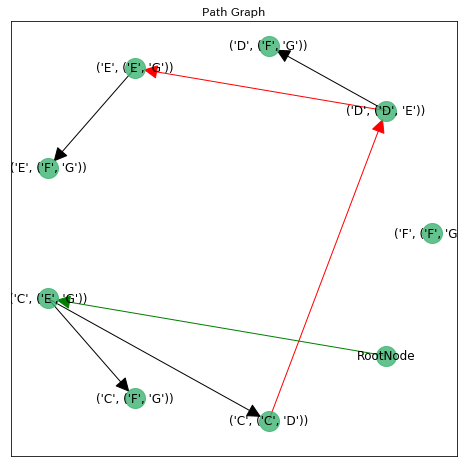

In [27]:
path_graph_pos = nx.shell_layout(P)
# path_graph_pos = nx.spring_layout(P)
labels = {v: v[1] for v in P}
labels['RootNode'] = 'RootNode'
plot_digraph3(P, pos=path_graph_pos, node_size=400, title='Path Graph', figsize=(8, 8), labels=None)

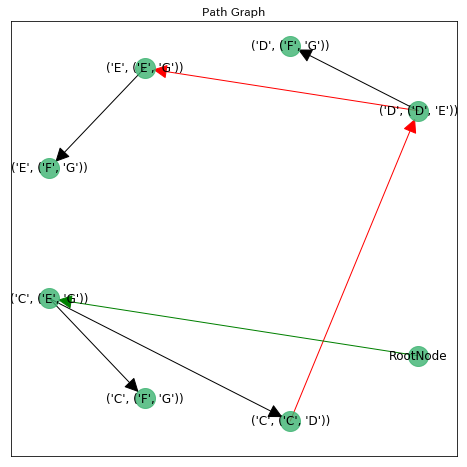

In [28]:
remain_edges = set()
for edge in nx.bfs_edges(P, source='RootNode'):
    remain_edges.add(edge)
plot_digraph3(P.edge_subgraph(remain_edges), pos=path_graph_pos, node_size=400, title='Path Graph', figsize=(8, 8), labels=None)

In [14]:
# find K - shortest path

def sidetracks2path(sidetracks, P, T, source, target, minus_weight):
    tmp_T = T.copy()
    for v, u in zip(sidetracks[1:], sidetracks[2:]):
        if P[v][u]['edge_type'] == 'cross_edge':
            tmp_T.add_edge(*v[1], weight=minus_weight)
    if len(sidetracks) > 1:
        last_sidetracks = sidetracks[-1]
        tmp_T.add_edge(*last_sidetracks[1], weight=minus_weight)
#     plot_digraph(tmp_T, pos, title='Shortest Path Tree')
    return nx.shortest_path(tmp_T, source=source, target=target, weight='weight')

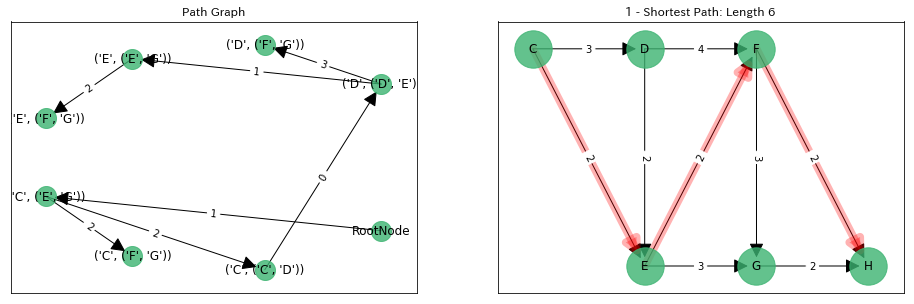

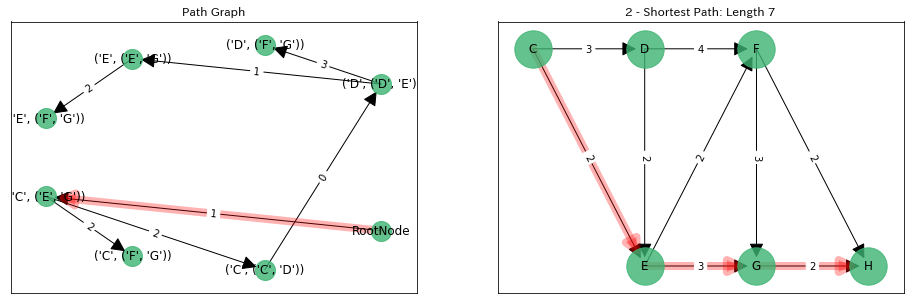

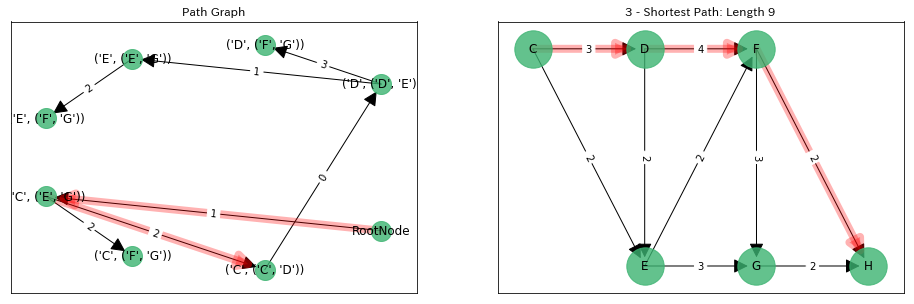

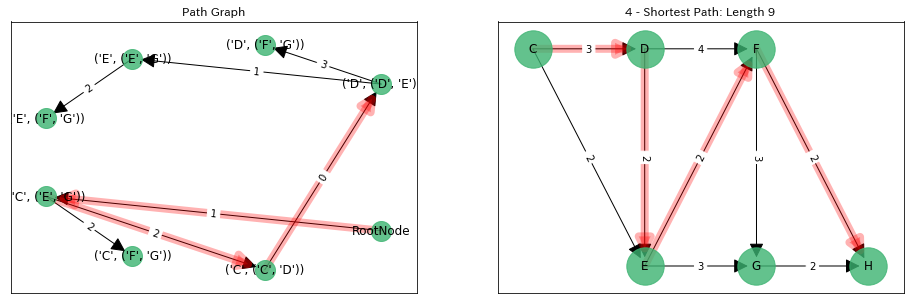

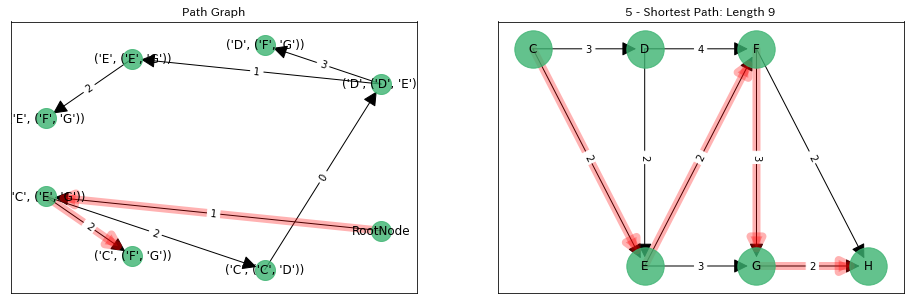

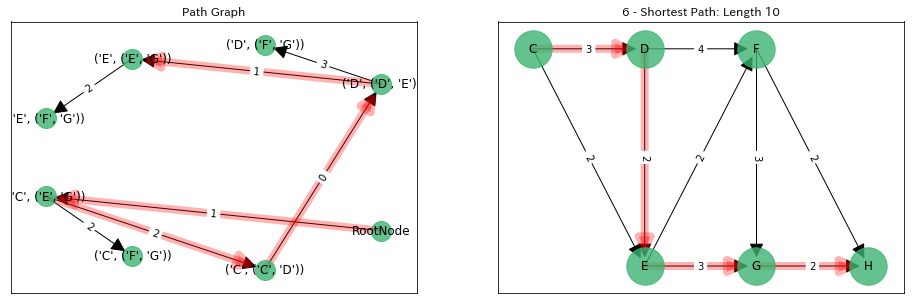

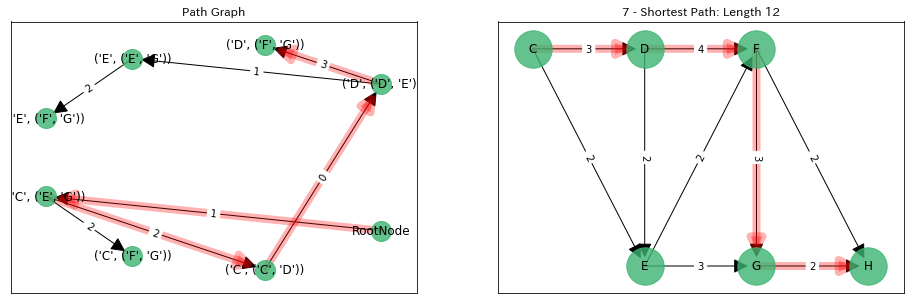

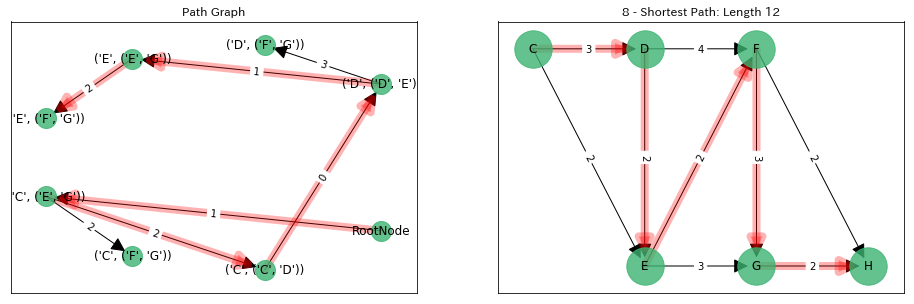

In [15]:
minus_weight = -sum(abs(T.edges[edge]['weight']) for edge in T.edges())
A = [] #  パス格納
B = [(0, ['RootNode'])] # 幅優先用キュー
k = 0
while B and k < K:
    potentials, sidetracks = heappop(B)
    A.append(sidetracks2path(sidetracks, P, T, source, target, minus_weight))
    last_sidetracks = sidetracks[-1]
    for v in P[last_sidetracks]:
        new_sidetracks = sidetracks + [v]
        new_potentials = potentials + P.edges[last_sidetracks, v]['weight']
        heappush(B, (new_potentials, new_sidetracks))
    from pprint import pprint
    k = k + 1
    if k == 1:
        shortest_path_length = sum(G[v][u]['weight'] for v, u in zip(A[-1], A[-1][1:]))
    length = shortest_path_length + potentials
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    plot_digraph4(G, A[-1], pos, f"{k} - Shortest Path: Length {length}", ax=axs[1])
    plot_digraph4(P.edge_subgraph(remain_edges), sidetracks, pos=path_graph_pos, node_size=400, title="Path Graph", figsize=(6, 6), ax=axs[0])